# Generate and Store Dataset

In [1]:
from BasicDataProcessing.generate_train_labels import list_audios
from BasicDataProcessing.generate_spectrograms import *
import numpy as np

In [2]:
audio_list = list_audios("../voxceleb1/vox1_dev_partaa/")
audio_list_test = list_audios("../voxceleb1/test/")

## Spectrograms specs

In [3]:
#Set the spectrograms specifications here and choose the type (log-mel or log-mel-normalized) 
#by running or  not the next sections
audio_ms = 3000 #Length of the audios in milliseconds
sampling_rate = 16000
n_mels = 64
window_ms = 20
stride_ms = 10
normalize = True
base_str = "melSpecSr"+str(audio_ms)+"ms"+str(sampling_rate)+"Hz"+str(n_mels)+"mels"+str(window_ms)+"wd"+str(stride_ms)+"st.bin"
if normalize:
    train_file_pickle = "spectrograms/Norm" + base_str
    test_file_pickle = "spectrograms/NormTest" + base_str 
    scaler_file_pickle = "spectrograms/Scaler" + base_str
else:
    train_file_pickle = "spectrograms/" + base_str
    test_file_pickle = "spectrograms/Test" + base_str 

### Creating new not Normalized spectrograms 

In [4]:
if normalize:
    print("Something is not right! You chose to normalize but this is the not normalized section")
import time
start_time = time.time()

%cd ../voxceleb1/vox1_dev_partaa/
spectrograms = mel_spectrograms(audio_list, audio_ms, sampling_rate, n_mels, window_ms, stride_ms)

%cd ../test/
spectrograms_test = mel_spectrograms(audio_list_test, audio_ms, sampling_rate, n_mels, window_ms, stride_ms)

print("--- %s seconds ---" % (time.time() - start_time))
print(len(spectrograms))
print(len(spectrograms_test))
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms["id10022/ZXYlWu1JfKU/00024.wav"], 16000, stride_size)
%cd ../../SpeakerVerificationML/

/Users/zeba/Desktop/speakerVerification/voxceleb1/vox1_dev_partaa


### Creating new Normalized spectrograms

In [4]:
if not normalize:
    print("Something is not right! You chose to not normalize but this is the normalized section")
import time
start_time = time.time()

%cd ../voxceleb1/vox1_dev_partaa/
spectrograms, train_scaler = mel_spectrogramsNormalized(audio_list, audio_ms, sampling_rate, n_mels, window_ms, stride_ms)

%cd ../test/
spectrograms_test = mel_spectrograms(audio_list_test, audio_ms, sampling_rate, n_mels, window_ms, stride_ms)
spectrograms_test = NormalizeDictUsingScaler(spectrograms_test, audio_list_test, train_scaler)

print("--- %s seconds ---" % (time.time() - start_time))
print(len(spectrograms))
print(len(spectrograms_test))
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms["id10022/ZXYlWu1JfKU/00024.wav"], 16000, stride_size)
%cd ../../SpeakerVerificationML/

/Users/zeba/Desktop/speakerVerification/voxceleb1/vox1_dev_partaa
/Users/zeba/Desktop/speakerVerification/voxceleb1/test
--- 465.04334330558777 seconds ---
48840
4874
/Users/zeba/Desktop/speakerVerification/SpeakerVerificationML


## Dumps spectrograms using pickle

In [5]:
#If hasn't saved the spectrograms in a file
import pickle
start_time = time.time()
    
with open(train_file_pickle, "wb") as myFile:
    pickle.dump(spectrograms, myFile)
    
with open(test_file_pickle, "wb") as myFile:
    pickle.dump(spectrograms_test, myFile)

if normalize:
    with open(scaler_file_pickle, "wb") as myFile:
        pickle.dump(train_scaler, myFile)
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 38.605676889419556 seconds ---


## Loading spectrograms

How to load the spectrograms using Pickle (the path might change)

In [7]:
#If only wants to load:
import pickle

with open(train_file_pickle, "rb") as myFile:
    spectrograms = pickle.load(myFile)
    
with open(test_file_pickle, "rb") as myFile:
    spectrograms_test = pickle.load(myFile)

if normalize:
    with open(scaler_file_pickle, "rb") as myFile:
        train_scaler = pickle.load(myFile)

(64, 301)

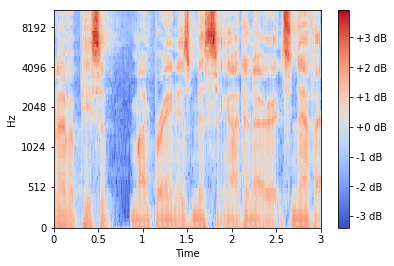

In [10]:
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms["id10022/ZXYlWu1JfKU/00024.wav"], 16000, stride_size)
spectrograms["id10022/ZXYlWu1JfKU/00024.wav"].shape

In [47]:
train_list_audios_x = []
train_list_y = []
with open("../voxceleb1/veri_train.txt") as train_labels_file:
    for line in train_labels_file:
        splitted = line.split()
        train_list_y.append(splitted[0])
        train_list_audios_x.append([splitted[1],splitted[2]])

train_y = np.zeros((len(train_list_y), 1))

for i in range(len(train_list_y)):
    train_y[i] = train_list_y[i]
    
print(train_y.shape)
print(len(train_list_audios_x))

(311260, 1)
311260


In [7]:
train_list_audios_x[311259]

['id10216/UoDyUyAe6O4/00005.wav', 'id10216/AEI-0E-jiF4/00007.wav']

In [8]:
#Generates mini batches using the spectrograms as channels. A pair = 2 channels
def generate_mini_batch(size, index, spectrograms, spec_shape, train_y, train_list_audios_x):
    min_index = index*size
    max_index = len(train_list_audios_x) if (len(train_list_audios_x) <= (index+1)*size) else (index+1)*size
    
    mini_batch_x = np.zeros((max_index - min_index, 2, spec_shape[0], spec_shape[1]))
    mini_batch_y = train_y[min_index : max_index]
    for i in range(min_index, max_index):
        mini_batch_x[i - min_index][0] = spectrograms[train_list_audios_x[i][0]]
        mini_batch_x[i - min_index][1] = spectrograms[train_list_audios_x[i][1]]
        
    return mini_batch_x, mini_batch_y
    

In [9]:
generate_mini_batch(16, 19452, spectrograms, (64, 301), train_y, train_list_audios_x)

(array([[[[-44.85087585, -32.35400391, -29.88194466, ..., -37.34885788,
           -36.93446732, -11.45058441],
          [-38.27891541, -36.18994141, -31.11603737, ..., -32.07846069,
           -17.83762169, -10.04480362],
          [-41.30822754, -38.46740723, -35.9896698 , ..., -29.40718269,
           -12.47841835, -15.40632439],
          ...,
          [-78.40619659, -74.11980438, -71.3182373 , ..., -40.20526123,
           -39.71114349, -43.43927765],
          [-74.77893829, -75.38790131, -72.09797668, ..., -44.49540329,
           -41.53761292, -45.01148987],
          [-76.86573792, -74.52418518, -75.27624512, ..., -44.96780396,
           -43.89508057, -46.45248032]],
 
         [[-23.04561234, -49.52103424, -45.16053009, ..., -35.60456848,
           -45.74680328, -43.25532532],
          [-23.28510475, -43.63887024, -50.95021057, ..., -26.02960396,
           -39.07238007, -49.72969818],
          [-21.21988487, -38.32309723, -36.53411865, ..., -28.21964455,
           -34

Sanity check

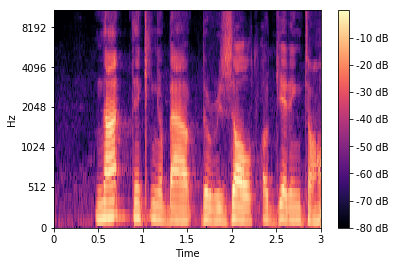

In [10]:
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms['id10545/AXUSWMHVUfM/00023.wav'], 16000, stride_size)

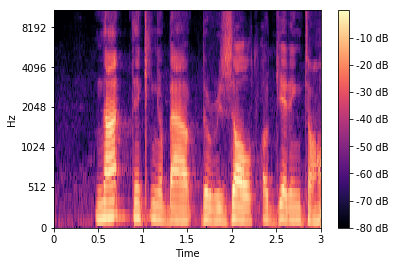

In [11]:
mini_batch_x, mini_batch_y = generate_mini_batch(1, 0, spectrograms, (64, 301), train_y, train_list_audios_x)
display_spectrogram(mini_batch_x[0][0], 16000, stride_size)

In [48]:
#Generate test datasets
test_list_audios_x = []
test_list_y = []
with open("../voxceleb1/veri_test.txt") as test_labels_file:
    for line in test_labels_file:
        splitted = line.split()
        test_list_y.append(splitted[0])
        test_list_audios_x.append([splitted[1],splitted[2]])

test_y = np.zeros((len(test_list_y), 1))

for i in range(len(test_list_y)):
    test_y[i] = test_list_y[i]

#test_x, test_y = generate_mini_batch(len(test_list_audios_x), 0, spectrograms_test, (spec_shape, test_y, test_list_audios_x)

print(test_y.shape)
#print(test_x.shape)

(37720, 1)


# Model Protoypes

In [74]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from math import ceil

from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import backend
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy

backend.set_floatx('float32')

In [75]:
# Get the model.
inputs = Input(shape=(2, 64, 301), name='spectrograms')
x = Flatten()(inputs)
x = Dense(32, activation='relu', name='dense_1')(x)
x = Dense(32, activation='relu', name='dense_2')(x)
outputs = Dense(2, name='predictions')(x)
model = Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer.
optimizer = Adam(learning_rate=1e-5)
# Instantiate a loss function.
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

In [76]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1232928   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
predictions (Dense)          (None, 2)                 66        
Total params: 1,234,050
Trainable params: 1,234,050
Non-trainable params: 0
_________________________________________________________________


In [71]:
epochs = 1
mini_batch_size = 512
spec_shape = (64, 301)

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    last_index = ceil(len(train_list_audios_x) / mini_batch_size)

    # Iterate over the batches of the dataset.
    for step in range(last_index):
    #for step in range(2):
        mini_batch_x, mini_batch_y = generate_mini_batch(mini_batch_size, step, spectrograms, spec_shape, train_y, train_list_audios_x)

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(mini_batch_x, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(mini_batch_y, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * mini_batch_size))

Start of epoch 0
Training loss (for one batch) at step 0: 5.151999473571777
Seen so far: 512 samples
Training loss (for one batch) at step 200: 1.176466703414917
Seen so far: 102912 samples
Training loss (for one batch) at step 400: 1.0195391178131104
Seen so far: 205312 samples
Training loss (for one batch) at step 600: 0.945184588432312
Seen so far: 307712 samples


In [64]:
#Evaluates on a dataset using SparseCategoricalAccuracy
def evaluate_mini_batches_SparCateAccuracy(model, mini_batch_size, spec_shape, test_y, test_list_audios_x, spectrograms):
    test_acc_metric = SparseCategoricalAccuracy()

    last_index = ceil(len(test_list_audios_x) / mini_batch_size)

    # Iterate over the batches of the dataset.
    for step in range(last_index):
        mini_batch_x, mini_batch_y = generate_mini_batch(mini_batch_size, step, spectrograms, spec_shape, test_y, test_list_audios_x)
        test_logits = model(mini_batch_x)
        # Update val metrics
        test_acc_metric(mini_batch_y, test_logits)
    test_acc = test_acc_metric.result()
    test_acc_metric.reset_states()
    return float(test_acc)

In [65]:
mini_batch_size = 512
evaluate_mini_batches_SparCateAccuracy(model, mini_batch_size, spec_shape, test_y, test_list_audios_x, spectrograms_test)

0.5053287148475647

In [78]:
#Evaluation on test
test_acc_metric = SparseCategoricalAccuracy()

mini_batch_size = 2

last_index = ceil(len(test_list_audios_x) / mini_batch_size)

# Iterate over the batches of the dataset.
for step in range(2):
    mini_batch_x, mini_batch_y = generate_mini_batch(mini_batch_size, step, spectrograms_test, spec_shape, test_y, test_list_audios_x)
    test_logits = model(mini_batch_x)
    print(test_logits)
    # Update val metrics
    test_acc_metric(mini_batch_y, test_logits)
test_acc = test_acc_metric.result()
test_acc_metric.reset_states()
print('Test accuracy: %s' % (float(test_acc),))

tf.Tensor(
[[-12.417724   7.969656]
 [-20.66334    6.404907]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-13.712068   9.671943]
 [ -6.614203  11.287223]], shape=(2, 2), dtype=float32)
Test accuracy: 0.5


In [77]:
mini_batch_size = 512
evaluate_mini_batches_SparCateAccuracy(model, mini_batch_size, spec_shape, train_y, train_list_audios_x, spectrograms)

0.5